## Problem Statement
In this challenge, participants will be tasked with distinguishing between essays crafted by students and those generated by a Language Model (LLM). The training dataset comprises 212 unique records, each identified by an 'id,' and participants will utilize information from 'prompt_id,' 'text,' and 'generated' fields to develop models that accurately predict the origin of each essay.

 

The test dataset, consisting of 188 records, lacks the 'generated' field, presenting the ultimate test for participants to assess the generalization of their models. The crux of the competition lies in comprehending and analyzing the context of the essays, as the training prompts are provided separately in the 'train_prompts.csv' file. With 'prompt_id' serving as a link between essays and prompts, participants will explore the 'prompt_name,' 'instructions,' and 'source_text' fields to gain insights into the background information influencing essay writing.


### Dataset 
The train dataset contains 212 records and the test data contains 188 records. Here is the description of the data.

train|test.csv

id : A unique identifier for each essay.  
prompt_id : Identifies the prompt the essay was written in response to.  
text : The essay text.  
generated : Whether the essay was written by a student (1) or generated by an LLM (0). This field is the target and is not present in test.csv.  
train_prompts.csv - Essays were written in response to information in these fields.  

prompt_id - A unique identifier for each prompt.  
prompt_name - The title of the prompt.    
instructions - The instructions given to students.
source_text - The text of the article(s) the essays were written in response to, in Markdown format. Each article is preceded with its title in a heading, like # Title. When an author is indicated, their name will be given in the title after by. Not all articles have authors indicated. An article may have subheadings indicated like ## Subheading.  
sample_submission.csv - A submission file in the correct format.  

Source [MachineHack.com](https://machinehack.com/hackathons/llm_hackathon_decoding_discourse_ai_vs_human/data 'Original Source of Hackathon')

In [185]:
# importing necessary libraries
import numpy as np
import pandas as pd

In [186]:
import matplotlib.pyplot as plt
import seaborn as sns

In [187]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

In [188]:
# reding data
train = pd.read_csv("train.csv")
train_p = pd.read_csv("train_prompts.csv")

test = pd.read_csv("test.csv")

In [189]:
# lets check the other file
train_p.head()

,prompt_id,prompt_name,instructions,source_text
0,0,The Ideal Career Choice,\nWrite an explanatory essay to inform fellow ...,#How to Choose a Career: 7 Ways to Narrow Your...
1,1,Bottled water should be banned or not,\nWrite a letter to the government in which yo...,#Pro and Con: Bottled Water Ban | Britannica\n...


In [190]:
test.tail(5)

,id,prompt_id,text
183,8312d6fa,1,#Persuasive Essay On Tap Water - Internet Pu...
184,a46dc136,1,#The Importance Of Bottled Water - Internet ...
185,75bb5544,1,#Why Is Bottled Water Banned - Internet Publ...
186,2fa6f12a,1,#Environmental and Cultural Impact of Bottled ...
187,463be5e6,1,#Annie Leonard's The Story Of Bottled Water i...


In [191]:
train.head()

,id,prompt_id,text,generated
0,e663b2f5,0,The ideal career choice is one that aligns pas...,0
1,dc1bd601,0,The ideal career choice is one that aligns wit...,0
2,3f28d007,0,The ideal career choice is one that aligns wit...,0
3,46232258,0,The ideal career choice is one that aligns wit...,0
4,f9fff5c6,0,The ideal career choice is one that aligns wit...,0


In [192]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         212 non-null    object
 1   prompt_id  212 non-null    int64 
 2   text       212 non-null    object
 3   generated  212 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 6.8+ KB


In [193]:
train.describe()

,prompt_id,generated
count,212.000000,212.000000
mean,0.339623,0.867925
std,0.474702,0.339374
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


C:\Users\integrated\AppData\Local\Temp\ipykernel_19432\3421044215.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([classnames[int(x.get_text())] for x in ax.get_xticklabels()])


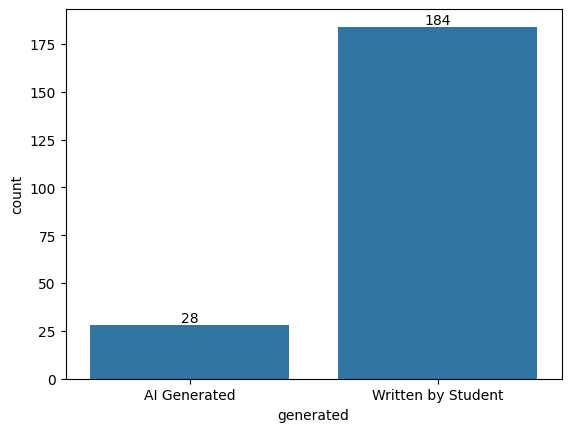

In [194]:
ax = sns.countplot(x='generated', data=train)

for containers in ax.containers:
    ax.bar_label(containers)
    
classnames = {0:"AI Generated", 1:"Written by Student"}
ax.set_xticklabels([classnames[int(x.get_text())] for x in ax.get_xticklabels()])
plt.show()

In [195]:
print(28/212*100)

13.20754716981132


only 13% percent of data is AI generated, so the data is imbalanced

In [196]:
# splitting x and y
x = train.drop(["generated"], axis=1)
y = train["generated"]

In [197]:
X_train, X_test , y_train, y_test = train_test_split(x,y, train_size=0.8, random_state=42)

In [198]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['text'])

### Applying SMOTE

In [199]:
smote = SMOTE(random_state=42)
X_train_resam, y_train_resam = smote.fit_resample(X_train_tfidf, y_train)

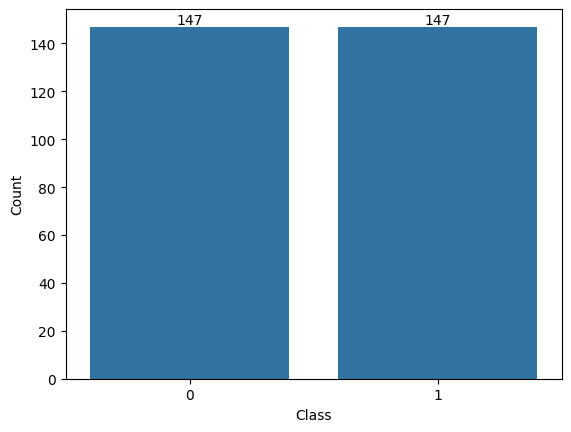

In [200]:
ax = sns.countplot(x=y_train_resam)

for containers in ax.containers:
    ax.bar_label(containers)
    

plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [209]:
model = LogisticRegression(random_state=42)
model.fit(X_train_resam, y_train_resam)

LogisticRegression(random_state=42)

In [210]:
y_pred = model.predict(X_test_tfidf)

In [211]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        37

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43

[[ 6  0]
 [ 0 37]]


ROC-AUC Score: 1.00


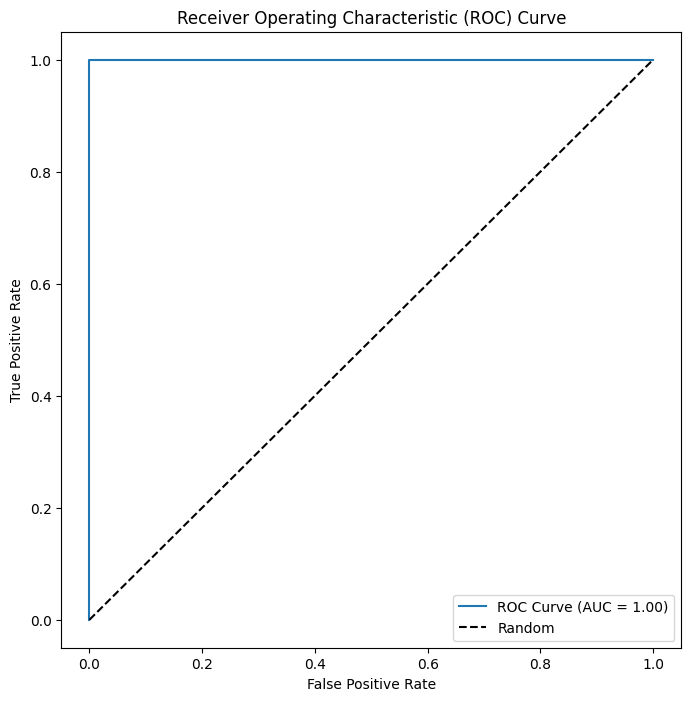

In [204]:
# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred)

print(f'ROC-AUC Score: {roc_auc:.2f}')

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [206]:
test_tfidf = tfidf_vectorizer.transform(test['text'])

In [212]:
y_hat = model.predict(test_tfidf)

In [218]:
df = pd.DataFrame(y_hat, columns=['generated'])

In [220]:
df.to_csv('output.csv', index=False) 

After Submission got 100% score and 28th rank on the leader board on MachineHack.com  
https://machinehack.com/hackathons/llm_hackathon_decoding_discourse_ai_vs_human/submission
![](Screenshot.jpg)